## Summary
* We tested 7 different feature sets with SVR, K Nearest Neighbors, and Ridge Regression set to default hyperparameters
* All feature sets were cleaned (no na values) and had the ID column removed
* The feature sets we tested were:
    * Original
    * Normalized original
    * Best 6 features using the k-best feature selection algorithm
    * Best 10 features using the k-best feature selection alg
    * Best 3 features using the k-best feature selection alg
    * Manually selected features based on the strongest correlations from the unaltered features
    * All features, including engineered ones (17 features total)

* We trained each regression type with each feature set and got the following results.

* Results: 
    * All models achieved a percent error between 10.1 and 13.61%
    * All models performed similarly in terms of cross validation with errors between 12.1 and 16.50% 
    * Using all the features, both original and engineered, with the ridge regression produced the strongest results 
    * However, we were not able to see significant improvements in the dataset based on feature selection 
        * This may be due to the small size of the dataset, with only 392 samples

* Next Steps:
    * Normalizing data before splitting into training and testing is data leakage
    * Encode categorical data instead of leaving as is or ignoring
    * Implement pipeline structures for more streamlined code

In [58]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn import preprocessing
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

## Outline
* Preprocess 
    * Get rid of missing values 
    * Get rid of superfluous features i.e. ID 
    * Normalize ? 
* Do exploratory data analysis
* Use feature selection algorithms
    * All features (no selection)
    * Variance score
    * Recursive feature elimination
    * Boruta 
    * Filter 
    * Manually selected using info from EDA 

* Cross validation
* Output results to dataframe; 1 dataframe for each model type or 1 exhaustive dataframe? 


## Notes
* ridge regression: good for multicollinearity
    * uses a specific loss function which penalizes larger errors more
* SVR: uses a kernel to transform the data
* K neighbors: bases the value of a point on its k nearest neighbors 

In [12]:
# preprocess and clean data
df = pd.read_csv("auto_1993_adj.csv")
df = df.drop("ID", axis =1)
df = df.dropna()

X = df.drop('mpg', axis = 1)
print(X.shape)
y = df['mpg']

#adding ratio because of high correlation
X['displacement/cylinders'] = X['displacement']/X['cylinders']

#normalizing values
scaler = preprocessing.StandardScaler()
X_norm = pd.DataFrame(scaler.fit_transform(X), columns = [f"{x}_norm" for x in X.columns])

#reset indices for concatenation
X.reset_index(drop = True, inplace= True)
X_norm.reset_index(drop = True, inplace= True)
#concatenating normalized values to features
X = pd.concat([X, X_norm], axis = 1)

#dropping normalized year and origin because they went to 0 bc discrete features 
X = X.drop(['model_year_norm', 'origin_norm'], axis = 1)
#log transformations of skewed distribution
X[['log_weight', 'log_displacement', 'log_horsepower']] = np.log(X[['weight', 'displacement', 'horsepower']])
print(X.shape)
print(y.shape)
X.head()

(392, 7)
(392, 17)
(392,)


,displacement,cylinders,horsepower,weight,acceleration,model_year,origin,displacement/cylinders,displacement_norm,cylinders_norm,horsepower_norm,weight_norm,acceleration_norm,displacement/cylinders_norm,log_weight,log_displacement,log_horsepower
0,307.0,8,130.0,3504,12.0,70,1,38.375,1.077290,1.483947,0.664133,0.620540,-1.285258,0.569276,8.161660,5.726848,4.867534
1,350.0,8,165.0,3693,11.5,70,1,43.750,1.488732,1.483947,1.574594,0.843334,-1.466724,1.187385,8.214194,5.857933,5.105945
2,318.0,8,150.0,3436,11.0,70,1,39.750,1.182542,1.483947,1.184397,0.540382,-1.648189,0.727397,8.142063,5.762051,5.010635
3,304.0,8,150.0,3433,12.0,70,1,38.000,1.048584,1.483947,1.184397,0.536845,-1.285258,0.526153,8.141190,5.717028,5.010635
4,302.0,8,140.0,3449,10.5,70,1,37.750,1.029447,1.483947,0.924265,0.555706,-1.829655,0.497403,8.145840,5.710427,4.941642


<Axes: >

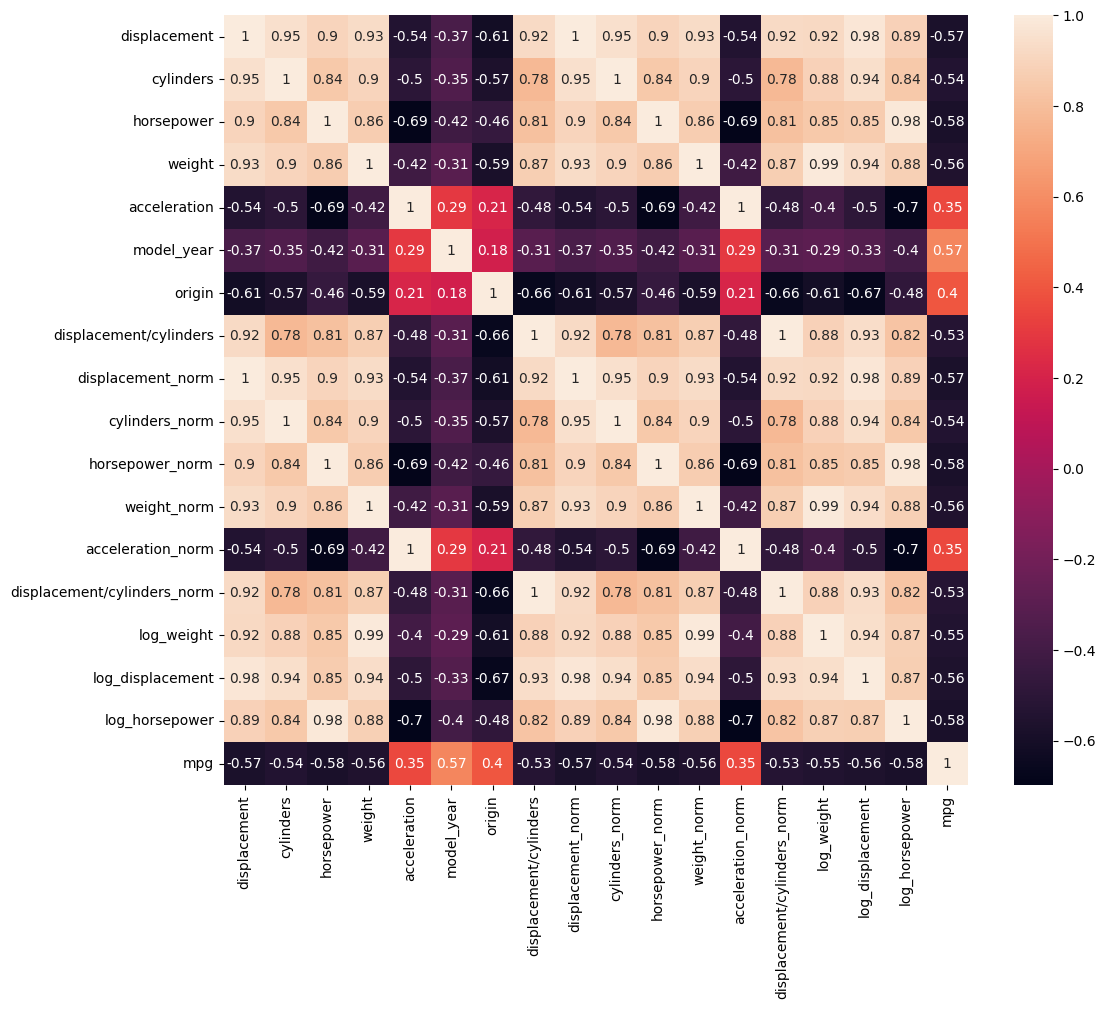

In [4]:
# correlation matrix
test = X.copy()
test['mpg'] = y
corr_matrix = test.corr()

plt.figure(figsize = (12,10))
sns.heatmap(corr_matrix, annot=True)
#strong correlation was displacement, cylinders, weight, horsepower


In [32]:
# mutual information
mi = mutual_info_regression(X, y)
features = X.columns
for i in range(len(mi)):
    print(f"{features[i]}: {mi[i]}")

#again displacement, cylinders, horsepower, weight are strongest

displacement: 0.7836601897666142
cylinders: 0.6185710491951089
horsepower: 0.7306754914342504
weight: 0.7842290100046139
acceleration: 0.2018178151008403
model_year: 0.3596513204936458
origin: 0.24300045154828287
displacement/cylinders: 0.6373936002836516
displacement_norm: 0.7897225401085399
cylinders_norm: 0.5843670615810093
horsepower_norm: 0.7142942555766085
weight_norm: 0.7835289322873886
acceleration_norm: 0.20502625420199871
displacement/cylinders_norm: 0.6512847006506628
log_weight: 0.7576220160492628
log_displacement: 0.800110922420612
log_horsepower: 0.7402000120591494


array([[<Axes: title={'center': 'displacement'}>,
        <Axes: title={'center': 'cylinders'}>,
        <Axes: title={'center': 'horsepower'}>],
       [<Axes: title={'center': 'weight'}>,
        <Axes: title={'center': 'acceleration'}>,
        <Axes: title={'center': 'model_year'}>],
       [<Axes: title={'center': 'origin'}>,
        <Axes: title={'center': 'mpg'}>, <Axes: >]], dtype=object)

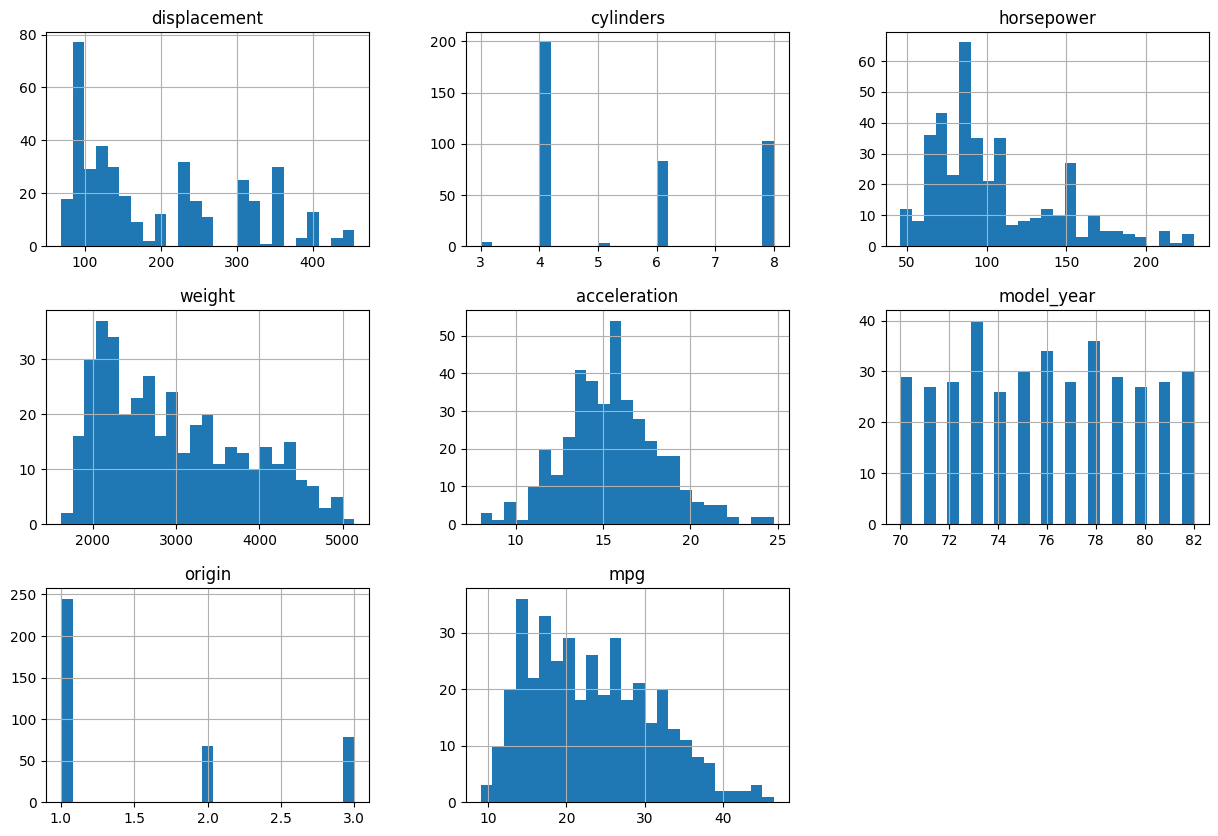

In [16]:
# histogram
test.hist(bins = 25, figsize = (15,10))


In [45]:
# feature selection
og_features = list(df.drop('mpg',axis =1).columns)

normalized = list(X_norm.drop(['model_year_norm', 'origin_norm'], axis = 1).columns)[:5]
normalized.append('model_year')
normalized.append('origin')

#kbest filtering
selector = SelectKBest(mutual_info_regression, k = 6)
selector.fit(X, y)
kbest = list(X.columns[list(selector.get_support())])

#kbest with diff k 
selector = SelectKBest(mutual_info_regression, k = 10)
selector.fit(X, y)
kbest_more = list(X.columns[list(selector.get_support())])

selector = SelectKBest(mutual_info_regression, k = 3)
selector.fit(X, y)
kbest_less = list(X.columns[list(selector.get_support())])

manual = ['displacement', 'weight', 'cylinders', 'horsepower']

#manual = ['log_displacement', 'acceleration_norm', 'log_horsepower', 'cylinders_norm', 'weight_norm']
all = list(X.columns)

#return list of features to use
feature_combos = [og_features, normalized, kbest, kbest_more, kbest_less, manual, all]
feature_combos_name = ["og_features", "normalized", "kbest", "kbest_more", "kbest_less", "manual", 'all']
for f in feature_combos:
    print (f)



['displacement', 'cylinders', 'horsepower', 'weight', 'acceleration', 'model_year', 'origin']
['displacement_norm', 'cylinders_norm', 'horsepower_norm', 'weight_norm', 'acceleration_norm', 'model_year', 'origin']
['displacement', 'weight', 'displacement_norm', 'weight_norm', 'log_weight', 'log_displacement']
['displacement', 'horsepower', 'weight', 'displacement/cylinders', 'displacement_norm', 'horsepower_norm', 'weight_norm', 'log_weight', 'log_displacement', 'log_horsepower']
['weight', 'weight_norm', 'log_displacement']
['displacement', 'weight', 'cylinders', 'horsepower']
['displacement', 'cylinders', 'horsepower', 'weight', 'acceleration', 'model_year', 'origin', 'displacement/cylinders', 'displacement_norm', 'cylinders_norm', 'horsepower_norm', 'weight_norm', 'acceleration_norm', 'displacement/cylinders_norm', 'log_weight', 'log_displacement', 'log_horsepower']


In [14]:
# create training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 99)
print(y_train.shape)


(313,)


In [40]:
# run models
model_stats = pd.DataFrame(columns = ['model', 'features', 'mse', 'percent error', 'r2', 'cross val percent error'])
models = [KNeighborsRegressor(), SVR(), Ridge()]

#run each model for each feature combo, for a total of 18 
for m in models:
    for i in range(len(feature_combos)):
        f = feature_combos[i]
        model = m    #can tweak hyperparameters if needed
        X_temp = X_train[f] #only get desired features
        model.fit(X_temp, y_train)
        pred = model.predict(X_test[f])
        mse = mean_squared_error(y_test, pred)
        percent_e = mean_absolute_percentage_error(y_test, pred)
        r2 = r2_score(y_test, pred)
        cross_val = cross_validate(m, X[f], y, scoring= ('r2', 'neg_mean_absolute_percentage_error'))
        cross_val_e = -pd.DataFrame(cross_val)['test_neg_mean_absolute_percentage_error'].mean() #take the avg of the percent error across all cv folds
        model_stats.loc[len(model_stats.index)] = [str(m), feature_combos_name[i], mse, percent_e, r2, cross_val_e]


In [261]:
# ridge tuning -- not signficant improvements to performance
stats = pd.DataFrame(columns = ['a', 'mse', 'percent error', 'r2'])
for a in range (1, 1000, 10):

    model = Ridge(alpha = a/100)
    X_temp = X_train[og_features]
    model.fit(X_temp, y_train)
    pred = model.predict(X_test[og_features])
    mse = mean_squared_error(y_test, pred)
    percent_e = mean_absolute_percentage_error(y_test, pred)
    r2 = r2_score(y_test, pred)
    stats.loc[len(stats.index)] = [a, mse, percent_e, r2]


In [41]:
model_stats.head(21)
# min = model_stats['percent error'].min()
# max = model_stats['percent error'].max()

# print(min, max)
# print(model_stats['cross val percent error'].min(), model_stats['cross val percent error'].max())

,model,features,mse,percent error,r2,cross val percent error
0,KNeighborsRegressor(),og_features,15.367484,0.112097,0.750164,0.154172
1,KNeighborsRegressor(),normalized,11.528147,0.095223,0.812582,0.110120
2,KNeighborsRegressor(),kbest,17.906881,0.121251,0.708880,0.159256
3,KNeighborsRegressor(),kbest_more,15.780142,0.113606,0.743456,0.155070
4,KNeighborsRegressor(),kbest_less,19.706471,0.133860,0.679624,0.159861
5,KNeighborsRegressor(),manual,15.403635,0.112800,0.749577,0.154978
6,KNeighborsRegressor(),all,15.289651,0.111765,0.751430,0.154655
7,SVR(),og_features,20.735229,0.128220,0.662899,0.151844
8,SVR(),normalized,52.982894,0.265008,0.138635,0.309871
9,SVR(),kbest,20.730839,0.128407,0.662970,0.152002


Text(0.5, 0, 'r2')

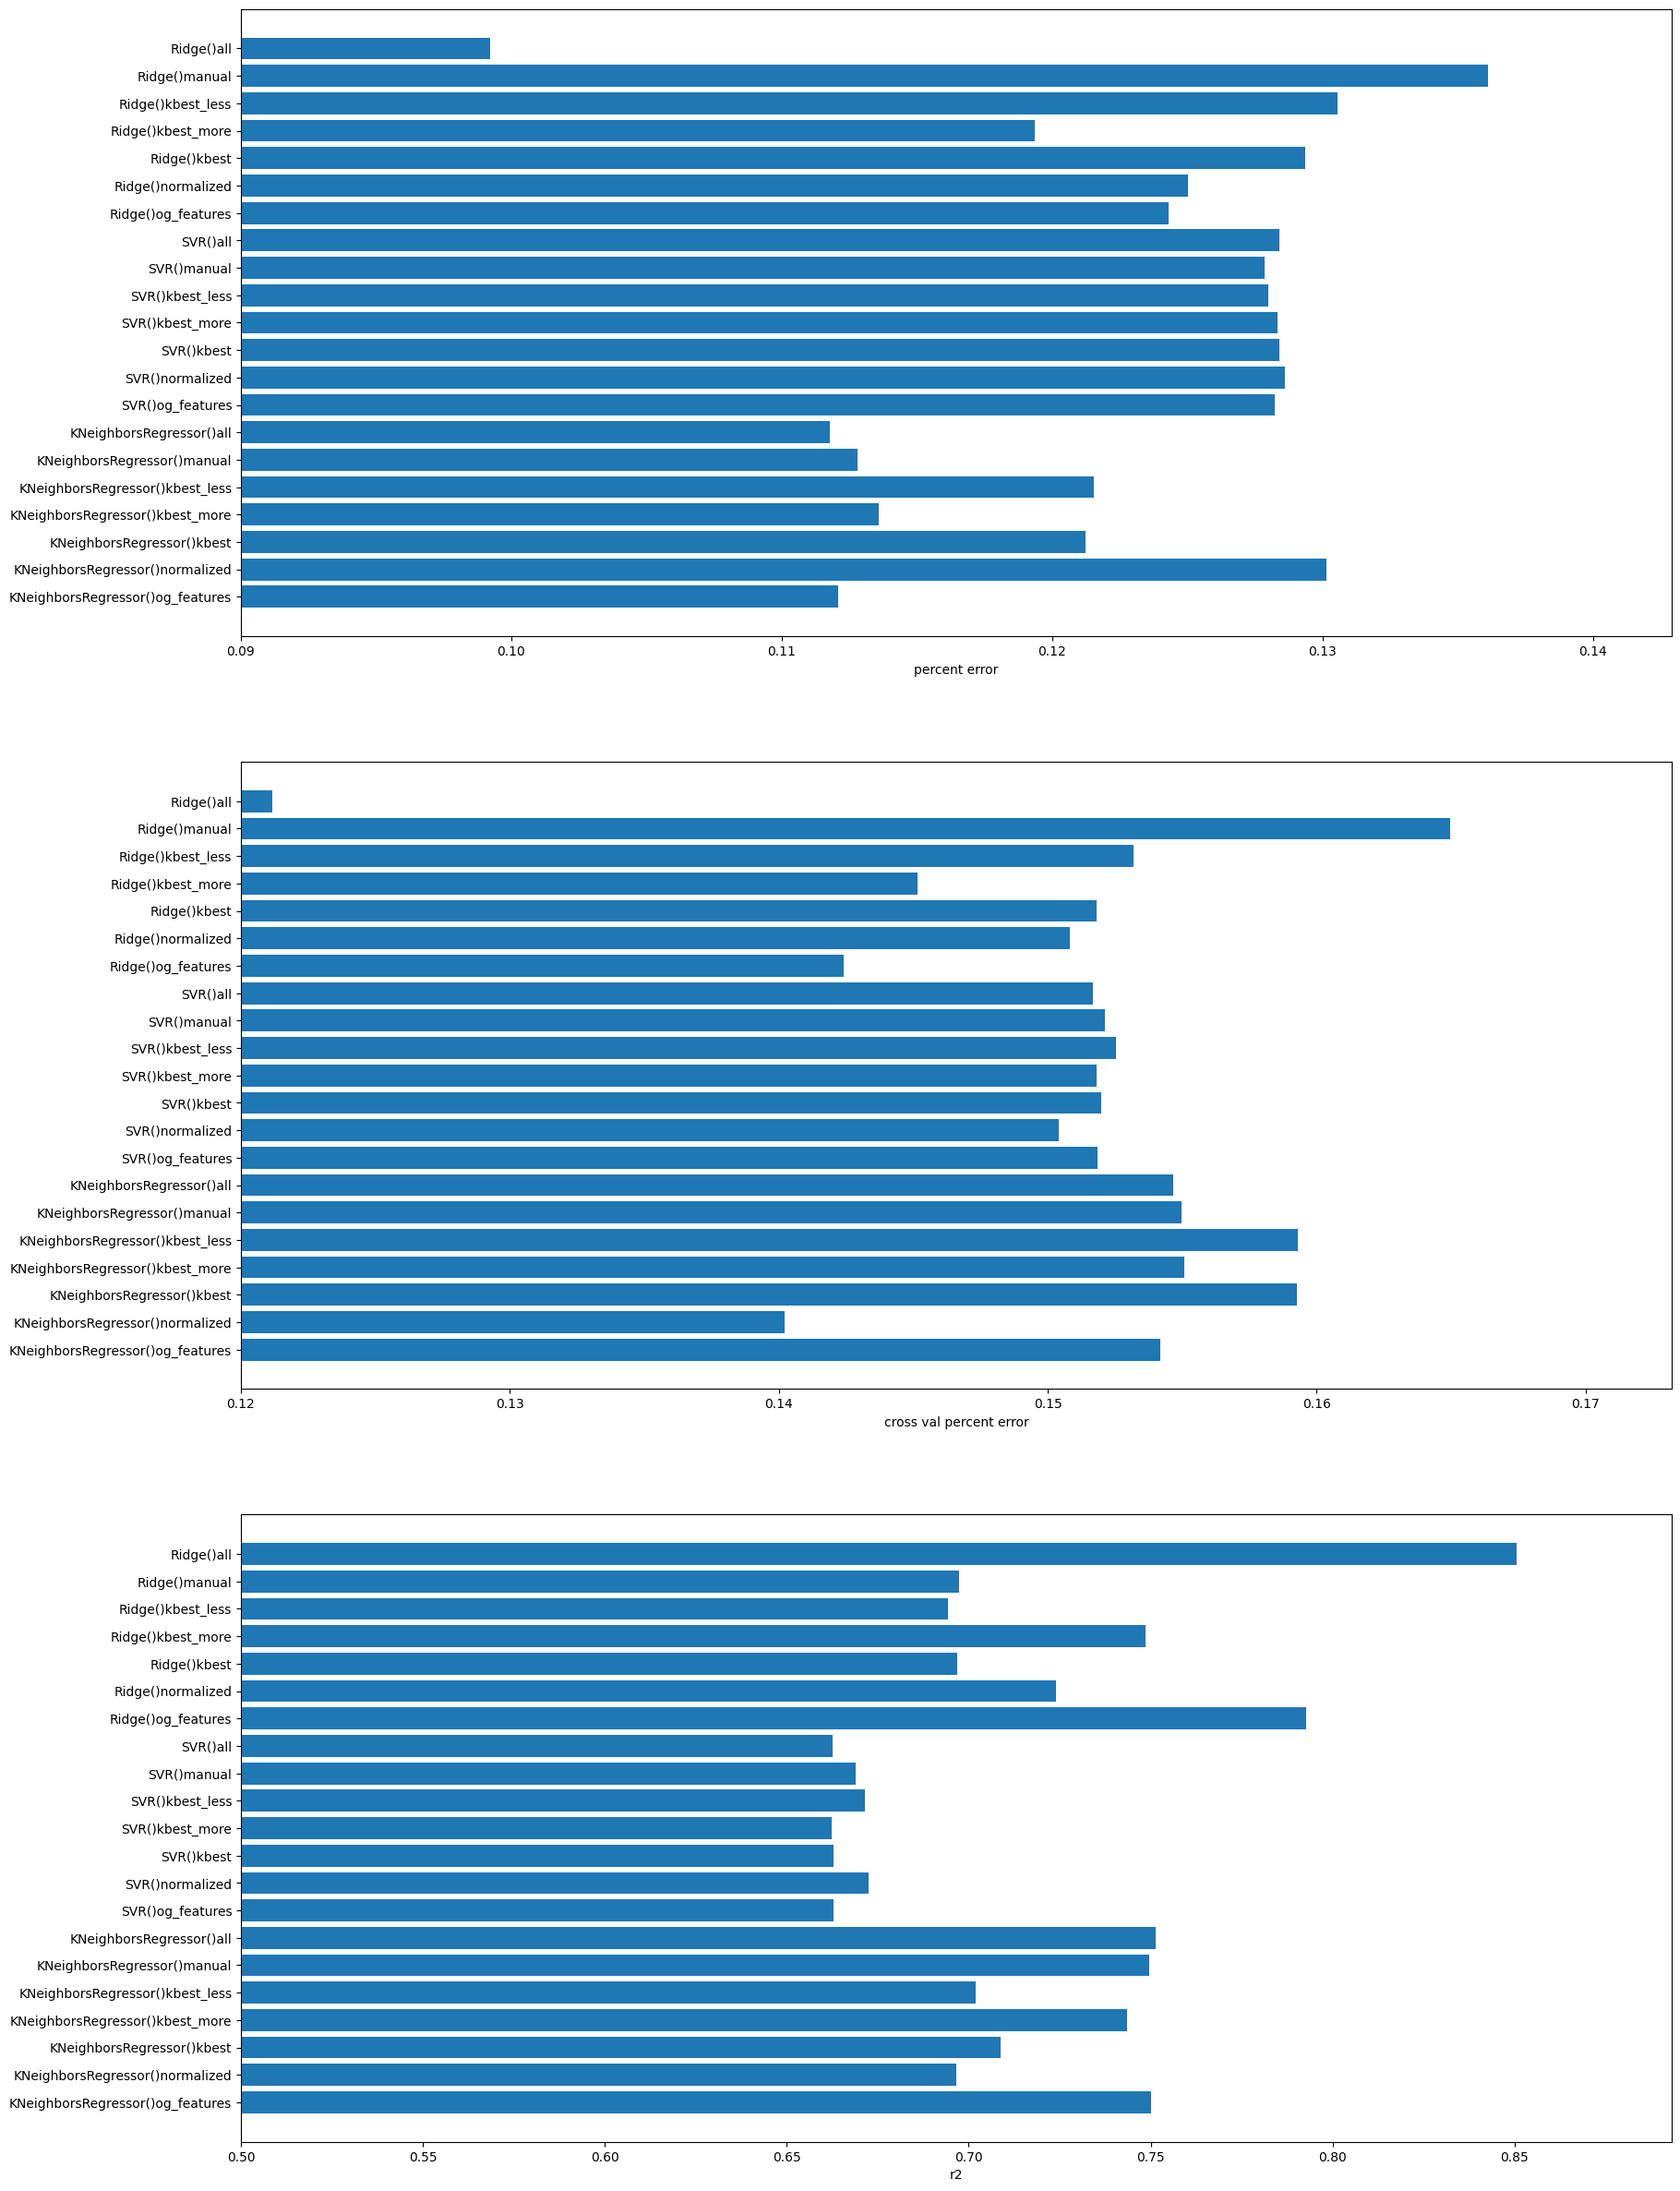

In [17]:
#visualization

model_stats['name'] = model_stats['model'] + model_stats['features']

fig, ax = plt.subplots(3,1, figsize = (20,30))
ax[0].barh(model_stats['name'], model_stats['percent error'])
ax[0].set_xlim(0.09)
ax[0].set_xlabel ("percent error")

ax[1].barh(model_stats['name'], model_stats['cross val percent error'])
ax[1].set_xlim(0.12)
ax[1].set_xlabel ("cross val percent error")

ax[2].barh(model_stats['name'], model_stats['r2'])
ax[2].set_xlim(0.5)
ax[2].set_xlabel ("r2")



Text(0.5, 1.0, 'Cross validation error')

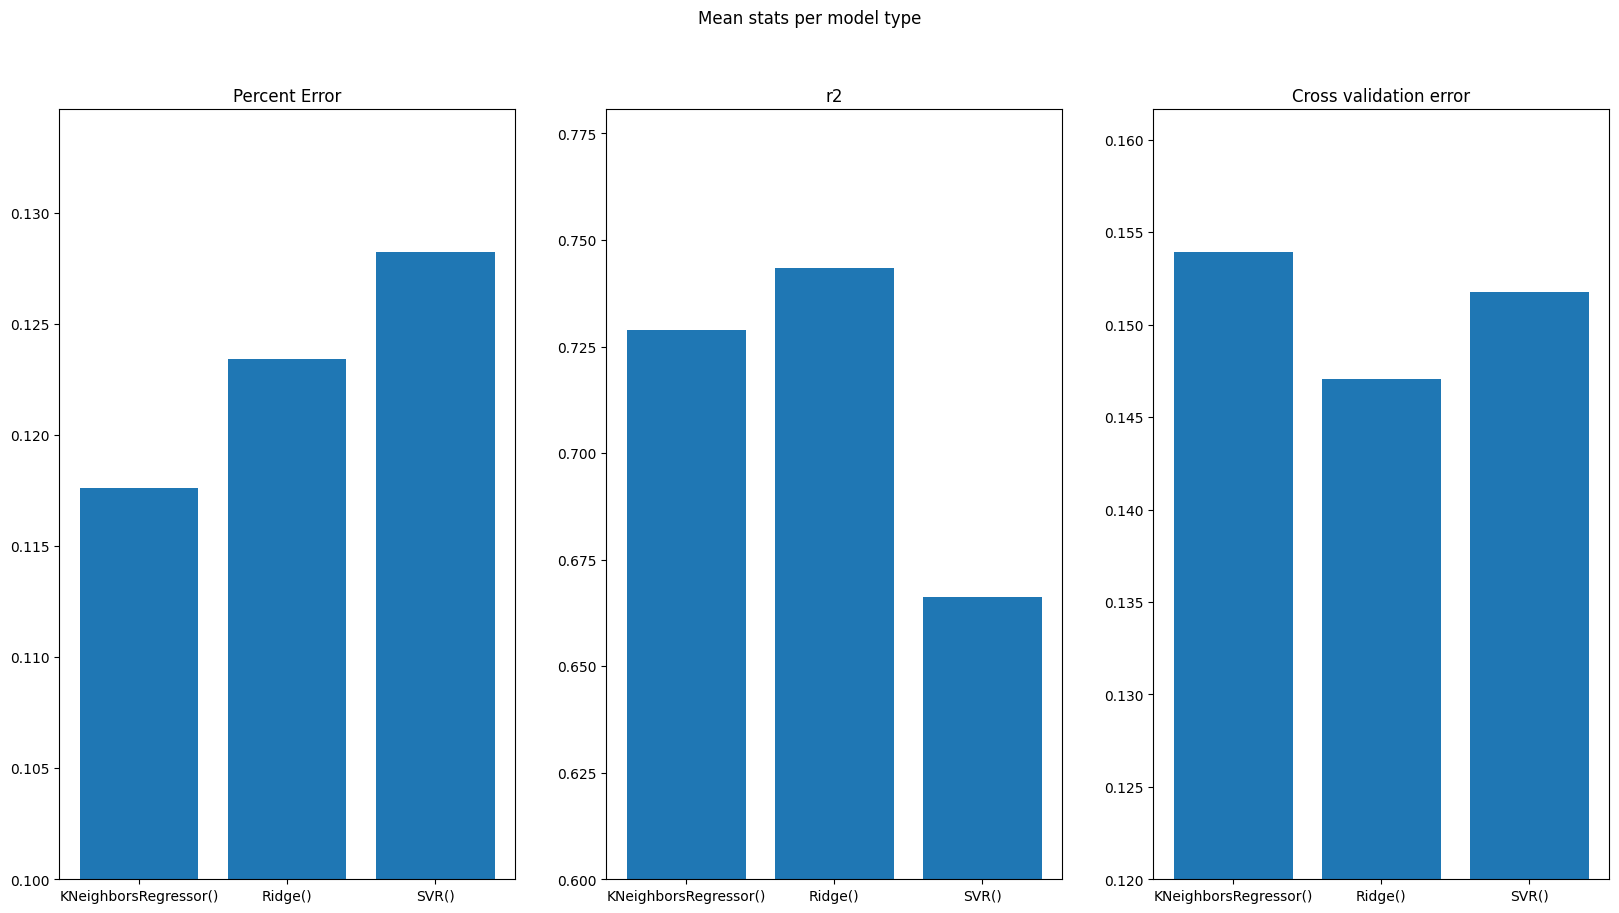

In [18]:
test = model_stats.drop('features', axis = 1).groupby('model').agg({'r2':'mean', 'percent error':'mean', 'mse' :'mean', 'cross val percent error' : 'mean' })
test.reset_index( inplace=True)
test.head()

plt.figure(figsize = (20,10))
plt.suptitle("Mean stats per model type")
plt.subplot(1,3,1)
plt.bar(test['model'], test['percent error'])
plt.ylim(0.1)
plt.title("Percent Error")


plt.subplot(1,3,2)
plt.bar(test['model'], test['r2'])
plt.ylim(0.6)
plt.title("r2")

plt.subplot(1,3,3)
plt.bar(test['model'], test['cross val percent error'])
plt.ylim(0.12)
plt.title("Cross validation error")




([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, 'all'),
  Text(1, 0, 'kbest'),
  Text(2, 0, 'kbest_less'),
  Text(3, 0, 'kbest_more'),
  Text(4, 0, 'manual'),
  Text(5, 0, 'normalized'),
  Text(6, 0, 'og_features')])

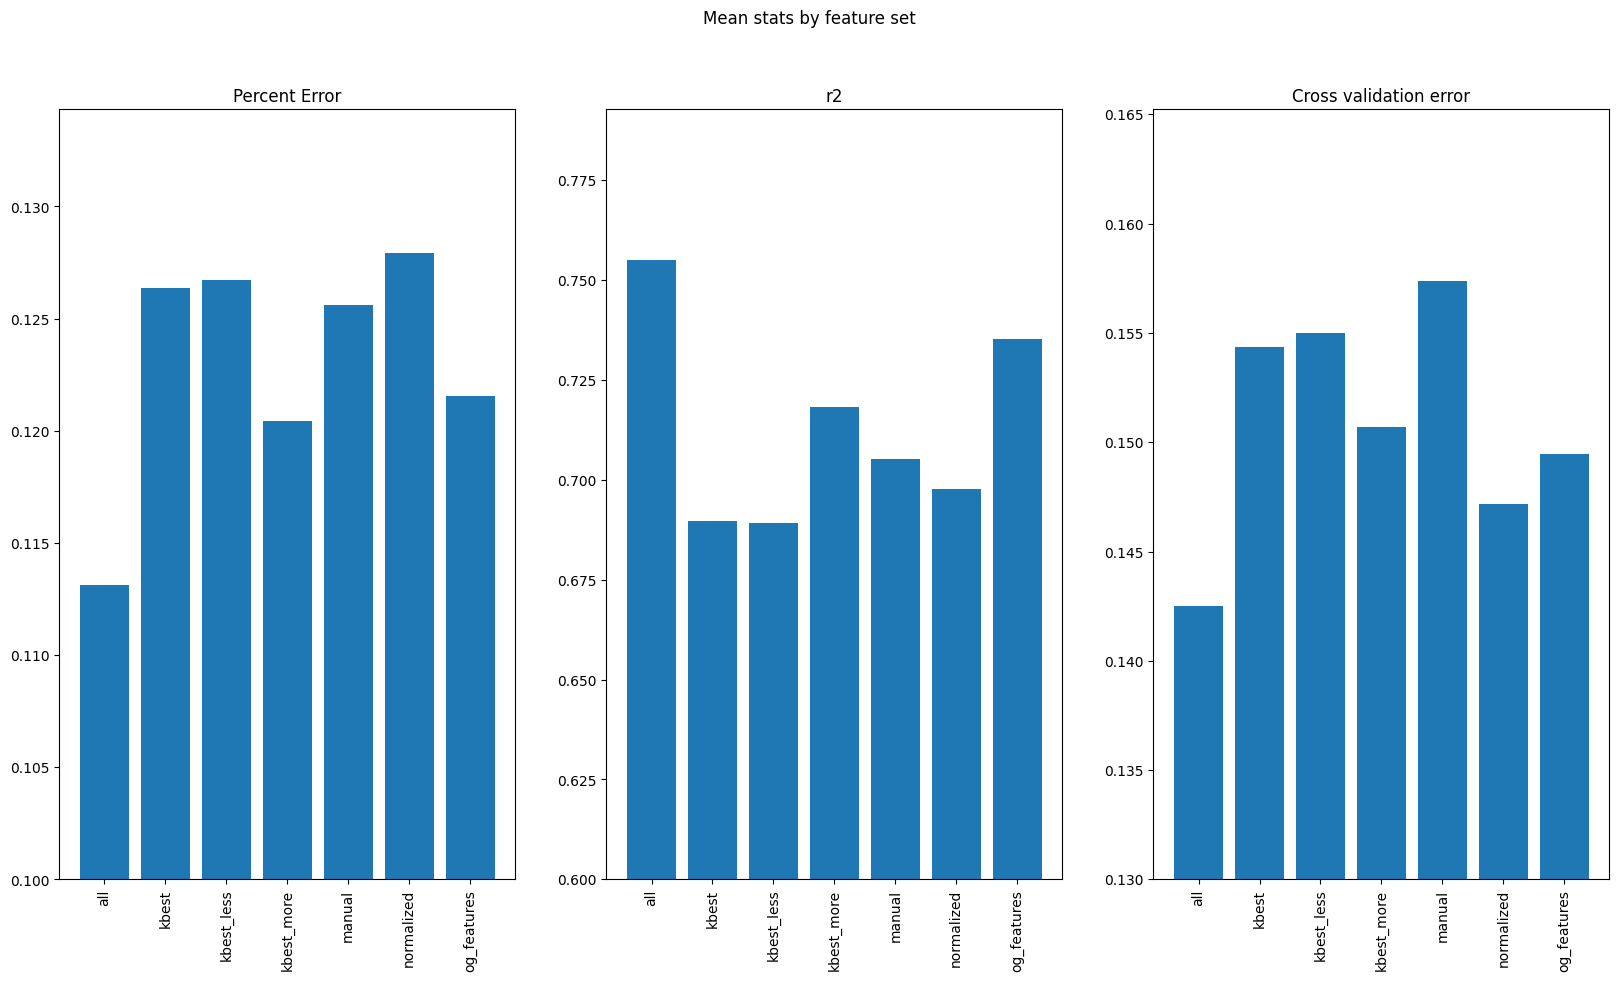

In [19]:
test = model_stats.drop('model', axis = 1).groupby('features').agg({'r2':'mean', 'percent error':'mean', 'mse' :'mean', 'cross val percent error' : 'mean' })
test.reset_index( inplace=True)
test.head()

plt.figure(figsize = (20,10))
plt.suptitle("Mean stats by feature set")
plt.subplot(1,3,1)
plt.bar(test['features'], test['percent error'])
plt.ylim(0.1)
plt.title("Percent Error")
plt.xticks(rotation='vertical') 

plt.subplot(1,3,2)
plt.bar(test['features'], test['r2'])
plt.ylim(0.6)
plt.title("r2")
plt.xticks(rotation='vertical') 

plt.subplot(1,3,3)
plt.bar(test['features'], test['cross val percent error'])
plt.ylim(0.13)
plt.title("Cross validation error")
plt.xticks(rotation='vertical') 